# Speaker Identification 

In [1]:
import os
import numpy as np
import pandas as pd
import soundfile as sf 
import matplotlib.pyplot as plt
from hmmlearn.hmm import GMMHMM
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [2]:
currentDirectory = os.getcwd()

In [3]:
data, samplerate = sf.read(currentDirectory+"/data/84/84-121123-0001.flac")

In [4]:
ipd.Audio(data=data, rate=samplerate)

Text(0.5, 1.0, 'Audio of a speaker')

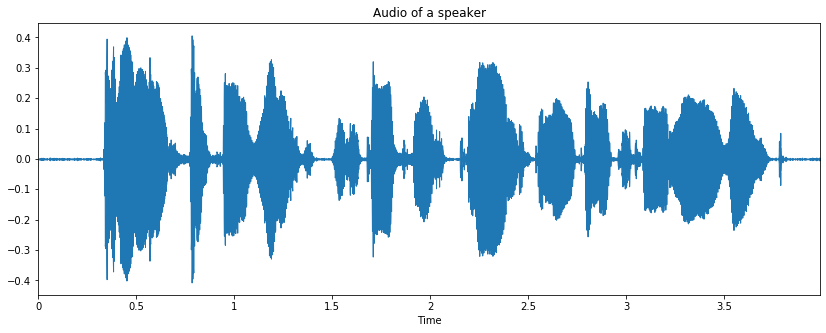

In [5]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(data, sr=samplerate)
plt.title('Audio of a speaker')

Text(0.5, 1.0, 'MFCC from Librosa')

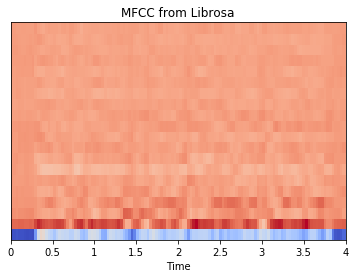

In [6]:
mfcc = librosa.feature.mfcc(y=data, sr=samplerate, n_mfcc=20)
librosa.display.specshow(mfcc, sr=samplerate, x_axis='time')
plt.title('MFCC from Librosa')

Text(0.5, 1.0, 'MFCC delta from Librosa')

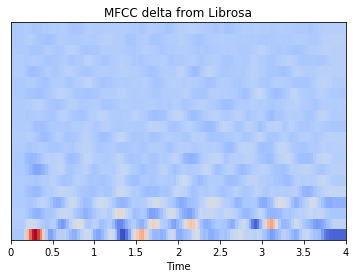

In [7]:
mfcc_delta = librosa.feature.delta(mfcc)
librosa.display.specshow(mfcc_delta, sr=samplerate, x_axis='time')
plt.title('MFCC delta from Librosa')

In [8]:
path = currentDirectory+"/data/"
speakers = ["84",
            "174",
            "251",
            "422",
            "652",
            "777",
            "1272",
            "1462", 
            "1673",
            "1919"]

min_duration = 5
deltaT = 1

## pre-processing 

In [9]:
def audio_file_read(speaker,label):
    fname = path+speaker+"/"
    files = [v for v in os.listdir(fname) if v[0] != "."]
    
    split = len(files) - int(len(files)*0.30)
    
    audio_data_test = []
    labels_test = []
    
    #Dividing the audio file into 1 second audio chunks for training
    for file in range(0,5):
        data,samplerate = sf.read(fname+files[file]) 
        
        dataT, index = librosa.effects.trim(data)
        duration = len(dataT)*1./samplerate
        
        if duration >= min_duration: 
            
            numChunks = int(duration/deltaT)
            sizeChunk = int(len(dataT)/numChunks)
            for lp in range(0,numChunks):    
                chunk = dataT[lp*sizeChunk:(lp+1)*sizeChunk]
                
                if lp != 0:
                    audio_data = np.vstack((audio_data,MFCC(chunk,samplerate)))
                else:
                    audio_data = MFCC(chunk,samplerate)
                    
    labels = np.full((1,audio_data.shape[0]), label)
    
    
    # Full test audio file
    for file in range(5,len(files)):
        data,samplerate = sf.read(fname+files[file]) 
        
        dataT, index = librosa.effects.trim(data)
        duration = len(dataT)*1./samplerate
        
        if duration >= min_duration:
            audio_data_test.append(MFCC(data,samplerate))
            labels_test.append(label)
    
    return audio_data,labels,audio_data_test,labels_test


def MFCC(audio_data,rate):
    
    mfcc_feat = librosa.feature.mfcc(y=audio_data, sr=rate, n_mfcc=20)
    mfcc_delta = librosa.feature.delta(mfcc_feat)
    
    features = np.hstack((mfcc_feat.T,mfcc_delta.T))
    
    return features

# GMMHMM Implementation

## Model Training

In [10]:
def gmmhmm():

    model = dict({})
    N = 0

    final_data = []
    final_label = []
    test_data = []
    test_label = []

    for speaker in speakers:

        data, label, dataT, labelT = audio_file_read(speaker,N)
        
        final_data.append(data)
        final_label.append(label)

        test_data.append(dataT)
        test_label.append(labelT)

        N +=1
    
    for index in range(0,len(speakers)):

        model[speakers[index]] = GMMHMM(n_components=1,n_mix=3).fit(final_data[index])
    
    return model, np.vstack(final_data), np.hstack(final_label), test_data, test_label

## Evaluation

In [11]:
gmmhmm_model, final_data_stacked, final_label, test_data, test_label = gmmhmm() 

C:\Users\ece_a\Anaconda3\lib\site-packages\librosa\effects.py:490: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[full_index], np.asarray([start, end])


In [12]:
final_test = []

for data in test_data:    
    for i in data:
        score_list=[]
        for model in gmmhmm_model: 
            score_list.append(gmmhmm_model[model].score(i))
        final_test.append(np.argmax(score_list))

In [13]:
# print('Train_Accuracy:',round(accuracy_score(final_label.tolist()[0], final)*100,2),'%')
print('Test_Accuracy:',round(accuracy_score(np.hstack(test_label), final_test)*100,2),'%')
# print('Train Confusion:')
# print(confusion_matrix(final_label.tolist()[0], final))
print('Test Confusion:')
print(confusion_matrix(np.hstack(test_label), final_test))

Test_Accuracy: 98.63 %
Test Confusion:
[[41  0  0  0  0  0  0  4  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 42  0  0  0  0  1  0  0]
 [ 0  0  0 26  0  0  0  0  0  0]
 [ 0  0  0  0 43  0  0  0  0  0]
 [ 0  0  0  0  0 35  0  0  0  0]
 [ 0  0  0  0  0  0 38  0  0  0]
 [ 0  0  0  0  0  0  0 31  0  0]
 [ 0  0  0  0  0  0  0  0 34  0]
 [ 0  0  0  0  0  0  0  0  0 41]]
